In [2]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
from xhistogram.xarray import histogram
import os
import time
from matplotlib.colors import LogNorm
import dask

In [3]:
listOfDir = os.listdir('/Data2/SubX/')
listOfDir = listOfDir[0:-1] # drop 'CWB
listOfDir

['ESRL', 'NASA', 'EMC', 'RSMAS', 'ECCC', 'NRL', 'CESM', 'NCEP']

In [5]:
subfolder_to_try = ['FIMr1p1','GEOS_V2p1','GEFS','CCSM4','GEPS5','GEPS6','hindcast','NESM','46LCESM1', '30LCAM5','CFSv2']

# the list above will look for the subfolder in the folder. I have 11 possibilities, one for each model. In particular

In [6]:
for ild in listOfDir:
    for isb in subfolder_to_try:
        if isb in os.listdir('/Data2/SubX/'+ild+'/'):
            print(ild+'/'+isb)


ESRL/FIMr1p1
NASA/GEOS_V2p1
EMC/GEFS
RSMAS/CCSM4
ECCC/GEPS5
ECCC/GEPS6
ECCC/hindcast
NRL/NESM
CESM/46LCESM1
CESM/30LCAM5
NCEP/CFSv2


## each of this subfloders are organized differently (in fact the third ECCC doesn't have a name for the submodel, but directly the folder hindcast. I assume that is the GEM model)

## Unfortunately I cannot use a general loop to treat each model, but I have to write a separate script for each of them

## the name of the variables *should* be the same: cape, tas_2m, tdps_2m, wap_500, pr_sfc

In [7]:
variable_names = ['cape', 'tas_2m', 'tdps_2m', 'wap_500', 'pr_sfc']

# NASA/GEOS_V2p1

In [8]:
for ild in listOfDir[1:2]:
    for isb in subfolder_to_try:
        if isb in os.listdir('/Data2/SubX/'+ild+'/'):
            subfolder_dir = ild+'/'+isb
            print(subfolder_dir)
            
            file_list = os.listdir('/Data2/SubX/'+subfolder_dir)
#             file_list1 = [ifl if ifl[-4:]!='.zip' else print('skip') for ifl in file_list]
            print(file_list)


NASA/GEOS_V2p1
['pr_sfc', 'rlut_toa', 'tas_2m', 'ts_sfc', 'ua_200', 'ua_850', 'va_200', 'va_850', 'zg_200', 'zg_500', 'forecast', 'startdates.txt', 'README', 'climatology', 'va_50', 'vas_10m', 'zg_10', 'zg_30', 'zg_50', 'get_GEOS_V2p1_hcast.pl', 'documentation.txt', 'vnames.pr2.txt', 'vnames.pr3.txt', 'cape', 'dlwrf_sfc', 'dswrf_sfc', 'hfls_sfc', 'hfss_sfc', 'huss_850', 'mrro', 'mrso', 'psl', 'sic', 'snc_sfc', 'snodp', 'stx_sfc', 'sty_sfc', 'swe', 'ta_10', 'ta_100', 'ta_30', 'ta_50', 'tasmax_2m', 'tasmin_2m', 'tdps_2m', 'ua_10', 'ua_100', 'ua_30', 'ua_50', 'uas_10m', 'ulwrf_sfc', 'uswrf_sfc', 'va_10', 'va_100', 'va_30', 'wap_500', 'zg_850', 'RMM', 'pentad_climatology', 'ROMI', 'get_GEOS_V2p1_SubX_fcst.pl', 'get_GEOS_V2p1_SubX_fcst_old20200529.pl']


In [9]:
for ild in listOfDir[1:2]:
    for isb in subfolder_to_try:
        if isb in os.listdir('/Data2/SubX/'+ild+'/'):
            subfolder_dir = ild+'/'+isb+'/'
            for ivar in variable_names:
                if ivar in os.listdir('/Data2/SubX/'+subfolder_dir):
                    var_subfolder_dir = '/Data2/SubX/'+subfolder_dir+ivar+'/'
                    file_list = os.listdir(var_subfolder_dir)
                    print(file_list)


['1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
['1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
['1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
['1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']
['1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']


In [11]:
from glob import glob
def pre_process_func(ds, strM):
    ds = ds.sel(lat=slice(23,50), lon=slice(230,300))
    ds.coords['S'] = ds.time[0].values
    ds.coords['S'] = ds.S - np.timedelta64(12,'h') 
    ds.coords['M'] = np.int(strM)
    ds.coords['time'] = ds.time-ds.S
    ds = ds.expand_dims(['S','M'])
    return ds
def read_netcdfs(files, dim, transform_func=None):
    def process_one_path(path):
        # use a context manager, to ensure the file gets closed after use
        with xr.open_dataset(path, chunks={}) as ds:
#             print(path)
            # transform_func should do some sort of selection or
            # aggregation
            if transform_func is not None:
                ds = transform_func(ds, path[-5:-3])
            # load all data from the transformed dataset, to ensure we can
            # use it after closing each original file
#             print(ds)
#             ds.load()
            return ds

    paths = sorted(glob(files))
#     print(paths)
    datasets = []
    for p in paths:
#         print(p)
        if (p.split('/')[6]=='2011')&(p.split('/')[7]=='jan'):
            print(p)
        else:
            datasets.append(process_one_path(p))
        
#     datasets = [process_one_path(p) for p in paths]
    
    combined = xr.combine_by_coords(datasets)
    combined = combined.chunk({'S':4,'M':-1})
    return combined



var_l=[]
for ivar in variable_names:
    print(ivar)
    if ivar in os.listdir('/Data2/SubX/NASA/GEOS_V2p1/'):    
        c_l = []
        for iy in np.arange(1999, 2017):
            print(iy)
            # here we suppose we only care about the combined mean of each file;
            # you might also use indexing operations like .sel to subset datasets
#             for im in np.arange()
            combined = read_netcdfs('/Data2/SubX/NASA/GEOS_V2p1/'+ivar+'/'+np.str(iy)+'/*/*.nc', dim=['S','M'],
                                    transform_func=pre_process_func)

            c_l.append(combined)
    all_values = xr.concat(c_l, dim='S') 
    var_l.append(all_values)
all_variables = xr.merge(var_l)

cape
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
/Data2/SubX/NASA/GEOS_V2p1/cape/2011/jan/cape_GMAOGEOS_01jan2011_00z_d01_d45_m01.nc
/Data2/SubX/NASA/GEOS_V2p1/cape/2011/jan/cape_GMAOGEOS_01jan2011_00z_d01_d45_m02.nc
/Data2/SubX/NASA/GEOS_V2p1/cape/2011/jan/cape_GMAOGEOS_01jan2011_00z_d01_d45_m03.nc
/Data2/SubX/NASA/GEOS_V2p1/cape/2011/jan/cape_GMAOGEOS_01jan2011_00z_d01_d45_m04.nc
/Data2/SubX/NASA/GEOS_V2p1/cape/2011/jan/cape_GMAOGEOS_06jan2011_00z_d01_d45_m01.nc
/Data2/SubX/NASA/GEOS_V2p1/cape/2011/jan/cape_GMAOGEOS_06jan2011_00z_d01_d45_m02.nc
/Data2/SubX/NASA/GEOS_V2p1/cape/2011/jan/cape_GMAOGEOS_06jan2011_00z_d01_d45_m03.nc
/Data2/SubX/NASA/GEOS_V2p1/cape/2011/jan/cape_GMAOGEOS_06jan2011_00z_d01_d45_m04.nc
/Data2/SubX/NASA/GEOS_V2p1/cape/2011/jan/cape_GMAOGEOS_11jan2011_00z_d01_d45_m01.nc
/Data2/SubX/NASA/GEOS_V2p1/cape/2011/jan/cape_GMAOGEOS_11jan2011_00z_d01_d45_m02.nc
/Data2/SubX/NASA/GEOS_V2p1/cape/2011/jan/cape_GMAOGEOS_11jan2011_00z_d01_d45_m03.nc
/Data2

2012
2013
2014
2015
2016
pr_sfc
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
/Data2/SubX/NASA/GEOS_V2p1/pr_sfc/2011/jan/pr_sfc_GMAOGEOS_01jan2011_00z_d01_d45_m01.nc
/Data2/SubX/NASA/GEOS_V2p1/pr_sfc/2011/jan/pr_sfc_GMAOGEOS_01jan2011_00z_d01_d45_m02.nc
/Data2/SubX/NASA/GEOS_V2p1/pr_sfc/2011/jan/pr_sfc_GMAOGEOS_01jan2011_00z_d01_d45_m03.nc
/Data2/SubX/NASA/GEOS_V2p1/pr_sfc/2011/jan/pr_sfc_GMAOGEOS_01jan2011_00z_d01_d45_m04.nc
/Data2/SubX/NASA/GEOS_V2p1/pr_sfc/2011/jan/pr_sfc_GMAOGEOS_06jan2011_00z_d01_d45_m01.nc
/Data2/SubX/NASA/GEOS_V2p1/pr_sfc/2011/jan/pr_sfc_GMAOGEOS_06jan2011_00z_d01_d45_m02.nc
/Data2/SubX/NASA/GEOS_V2p1/pr_sfc/2011/jan/pr_sfc_GMAOGEOS_06jan2011_00z_d01_d45_m03.nc
/Data2/SubX/NASA/GEOS_V2p1/pr_sfc/2011/jan/pr_sfc_GMAOGEOS_06jan2011_00z_d01_d45_m04.nc
/Data2/SubX/NASA/GEOS_V2p1/pr_sfc/2011/jan/pr_sfc_GMAOGEOS_11jan2011_00z_d01_d45_m01.nc
/Data2/SubX/NASA/GEOS_V2p1/pr_sfc/2011/jan/pr_sfc_GMAOGEOS_11jan2011_00z_d01_d45_m02.nc
/Data2/SubX/NASA/GEOS_V

In [12]:
#p = '/Data2/SubX/NASA/GEOS_V2p1/cape/2011/jan/'

In [13]:
all_variables

<xarray.Dataset>
Dimensions:  (M: 4, S: 1307, lat: 28, lev: 1, lon: 71, time: 45)
Coordinates:
  * lon      (lon) float32 230.0 231.0 232.0 233.0 ... 297.0 298.0 299.0 300.0
  * lat      (lat) float32 23.0 24.0 25.0 26.0 27.0 ... 46.0 47.0 48.0 49.0 50.0
  * time     (time) timedelta64[ns] 0 days 12:00:00 ... 44 days 12:00:00
  * M        (M) int64 1 2 3 4
  * S        (S) datetime64[ns] 1999-01-01 1999-01-06 ... 2016-12-22 2016-12-27
  * lev      (lev) float64 500.0
Data variables:
    cape     (S, M, time, lat, lon) float32 dask.array<chunksize=(4, 4, 45, 28, 71), meta=np.ndarray>
    tas      (S, M, time, lat, lon) float32 dask.array<chunksize=(4, 4, 45, 28, 71), meta=np.ndarray>
    tdps     (S, M, time, lat, lon) float32 dask.array<chunksize=(4, 4, 45, 28, 71), meta=np.ndarray>
    wap      (S, M, time, lev, lat, lon) float32 dask.array<chunksize=(4, 4, 45, 1, 28, 71), meta=np.ndarray>
    pr       (S, M, time, lat, lon) float32 dask.array<chunksize=(4, 4, 45, 28, 71), meta=np.nda

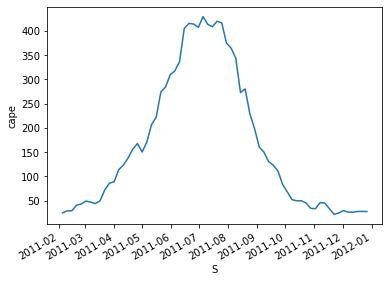

In [55]:
all_variables.cape.sel(S=slice('2011-01-01', '2011-12-28')).mean(dim=['lat','lon','M','time']).plot.line(add_legend=False)